Codes in this jupyter notebook shows work on ZVA05 (SAP data) from Jan 1, 2017 - May 31, 2015.

The overall goal is to predict monthly sum order quantity for each Product Category.

Dealers from sales office 'HYB' and 'STD' are segmented using the entire ZVA05 dataset into 4 volume groups: Small, Medium, Large and X-Large.

Algorithm tested: OLS, WLS, KNN, random forest.

Main conclusions:
- data is not homoskedastic, cannot use OLS regression, Pearson correlation, t-test and p-value.
- segment method is wrong (mix of training and testing data)

In [167]:
import pandas as pd
import numpy as np
import datetime
import pyodbc
import copy
import sys
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict, train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import levene, bartlett, boxcox
from graphviz import Source
from IPython.display import Image, SVG, display
from sklearn.tree import export_graphviz

In [ ]:
%store -r df_new
df_new.shape
df = df_new.copy()

## 1) Data Cleansing & Proprocessing
### 1.1) Label each dealer's Volume_Group
- classify each dealer into one of 4 distinct volume_groups based on their sum(Order_Qty) divided by the number of months being a customer
- only data points that fall within the timespan from Jan-01-2017 to May-31-2018 are considered for segmentation, analysis and modelling # __wrong approach__

In [22]:
vol3 = pd.read_csv('Volume3.csv', index_col = 0, dtype = {'Sold_to_Party':object})
vol3.shape

(5667, 2)

In [23]:
vol3.head(10)

,Sold_to_Party,Class
1318,0000101813,3
528,0000100710,3
1955,0000102853,3
1341,0000101886,3
642,0000100873,3
300,0000100395,2
236,0000100315,2
1657,0000102433,2
754,0000101026,2
1252,0000101711,2


In [24]:
# check the # of unique volume groups
np.unique(vol3.Class)

array([0, 1, 2, 3], dtype=int64)

In [205]:
# calculate the number of dealers in each volume group
def get_volume_group_size(group):
    return len(vol3.groupby(['Class']).groups[i])
for i in range(0,4):
    print("# of dealers in volume group {}: {}".format(i,get_volume_group_size(i)))

# of dealers in volume group 0: 5560
# of dealers in volume group 1: 87
# of dealers in volume group 2: 15
# of dealers in volume group 3: 5


In [206]:
volume_groups = vol3.set_index('Sold_to_Party')['Class'].to_dict()

In [207]:
len(volume_groups)

5667

In [7]:
# volume_groups = {'customerID':volume_groupID }
"""
{'0000101813': 3,
 '0000100710': 3,
 '0000102853': 3,
 '0000101886': 3,
 '0000100873': 3,
 '0000100395': 2,
 '0000100315': 2,
 '0000102433': 2,
 '0000101026': 2, ...}
"""
%store volume_groups

Stored 'volume_groups' (dict)


In [14]:
# Check for differences between volume grouping and all orders (customers who are segmented but not in orders list)
{ k: volume_groups[k] for k in set(volume_groups) - set(all_orders) }

{}

In [208]:
print("Delivery date range:", min(df['Line_Req_Deliv_Date']), max(df['Line_Req_Deliv_Date'])) 
print("Order date range:", min(df['Document_Date']), max(df['Document_Date']))

Delivery date range: 2017-01-01 2018-05-31
Order date range: 2017-02-04 2018-05-31


In [209]:
df = df[['Sales_document', 'Sold_to_Party', 'SalesOffice', 'Order_Type',
       'Unit_Price', 'Order_Qty', 'Document_Date', 'Req_Delivery_Date',
       'Goods_Issue_Date', 'Delivery_Date', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag', 'Line_Req_Deliv_Date',
       'Confirmed_Line_Quantity', 'Confirmed_Line_Value',
       'Overall_Credit_Status_Desc', 'Net_Value_Actual', 'ProductCategory',
       'MasterSKU', 'Color', 'CurrentFlag', 'CustomerID', 'Customer', 'City',
       'State', 'Zipcode', 'Country', 'District', 'waiting_days', 'wait']]
df.shape

(602653, 32)

### 1.2) Extract month and year of each row's order creation date and create two new columns

In [217]:
def add_year_month_cols():
    df['year'] = df.apply(lambda _: '', axis=1)
    df['month'] = df.apply(lambda _: '', axis=1)

def extract_order_year_month():
    df['Document_Date'] = pd.to_datetime(df['Document_Date'])
    df['year'], df['month'] = df['Document_Date'].dt.year, df['Document_Date'].dt.month

In [218]:
add_year_month_cols()
extract_order_year_month()
df.sample(2)

,Sales_document,Sold_to_Party,SalesOffice,Order_Type,Unit_Price,Order_Qty,Document_Date,Req_Delivery_Date,Goods_Issue_Date,Delivery_Date,...,Customer,City,State,Zipcode,Country,District,waiting_days,wait,year,month
108993,0020003485,0000107125,STD,QT,62.54,2.0,2017-04-23,2017-04-23,2017-05-17,2017-05-22,...,Surfside Sports,Costa Mesa,CA,92627-3831,US,CALS,29,1,2017,4
419094,0010707927,0000101399,HYB,OR,185.24,1.0,2017-12-06,2017-12-14,2017-12-13,2017-12-15,...,DO It Best Corp,Fort Wayne,IN,46801-0868,US,INKY,8,1,2017,12


### 1.3) Append a new column to the end of each row indicating dealer's volume group 

In [219]:
df['dealer_volume_group'] = df.apply(lambda _: '', axis=1)
df.columns

Index(['Sales_document', 'Sold_to_Party', 'SalesOffice', 'Order_Type',
       'Unit_Price', 'Order_Qty', 'Document_Date', 'Req_Delivery_Date',
       'Goods_Issue_Date', 'Delivery_Date', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag', 'Line_Req_Deliv_Date',
       'Confirmed_Line_Quantity', 'Confirmed_Line_Value',
       'Overall_Credit_Status_Desc', 'Net_Value_Actual', 'ProductCategory',
       'MasterSKU', 'Color', 'CurrentFlag', 'CustomerID', 'Customer', 'City',
       'State', 'Zipcode', 'Country', 'District', 'waiting_days', 'wait',
       'year', 'month', 'dealer_volume_group'],
      dtype='object')

In [220]:
def update_dealer_volume_group():
    for i, row in df.iterrows():
        dealer = row[1]
        group = volume_groups[dealer]
        df.at[i, 'dealer_volume_group'] = group

In [221]:
update_dealer_volume_group()

In [224]:
df.sample(10)

,Sales_document,Sold_to_Party,SalesOffice,Order_Type,Unit_Price,Order_Qty,Document_Date,Req_Delivery_Date,Goods_Issue_Date,Delivery_Date,...,City,State,Zipcode,Country,District,waiting_days,wait,year,month,dealer_volume_group
590920,0011186228,0000103056,STD,OR,129.99,1.0,2018-05-17,2018-05-17,2018-05-24,2018-05-31,...,Oakdale,CA,95361,US,CALN,0,0,2018,5,0
285874,0010403338,0000101886,STD,OR,20.99,12.0,2017-08-08,2017-08-08,2017-08-10,2017-08-15,...,Mattoon,IL,61938-6643,US,ILWI,0,0,2017,8,3
52540,0010051792,0000100710,HYB,OR,27.99,12.0,2017-03-07,2017-03-08,2017-04-06,2017-04-11,...,Fargo,ND,58103,US,ILWI,1,1,2017,3,3
466407,0010914965,0000101711,STD,OR,14.24,72.0,2018-01-30,2018-01-30,2018-02-05,2018-02-05,...,Summerville,SC,29483-7338,US,GAS,0,0,2018,1,2
582338,0011169976,0000104235,STD,OR,14.99,6.0,2018-05-10,2018-05-10,2018-06-04,2018-06-06,...,Garden City,KS,67846-5426,US,KSMO,0,0,2018,5,0
244924,0010351419,0000100672,STD,OR,129.99,2.0,2017-07-17,2017-07-13,2017-07-18,2017-07-18,...,El Campo,TX,77437-4054,US,HOUST,-4,,2017,7,0
149242,0010170379,0000107458,STD,OR,47.99,12.0,2017-05-23,2017-09-28,2017-11-15,2017-11-20,...,Englishtown,NJ,07726-1622,US,NYC,128,1,2017,5,0
325607,0010461789,0000104070,STD,OR,11.99,12.0,2017-09-07,2017-09-07,2017-09-07,2017-09-08,...,Norman,OK,73069-5644,US,OKAR,0,0,2017,9,0
132173,0010125815,0000100192,STD,OR,14.99,6.0,2017-05-01,2017-06-05,2017-06-22,2017-06-27,...,Stroudsburg,PA,18360-2003,US,PANY,52,1,2017,5,0
362834,0010527234,0000115902,STD,OR,129.99,2.0,2017-10-11,2017-10-11,2017-10-11,2017-10-11,...,Galena,MD,21635,US,MATL,0,0,2017,10,0


In [238]:
data = df.copy()

### 1.4) Cleansing
- change empty fields (negative wait intervals) to NaN in 'wait' indicator
- replace Nulls and empty fields

In [239]:
data['wait'].replace('', np.nan, inplace=True)
# check for null fields
data.isnull().sum()

Sales_document                     0
Sold_to_Party                      0
SalesOffice                        0
Order_Type                         0
Unit_Price                         0
Order_Qty                          0
Document_Date                      0
Req_Delivery_Date                  0
Goods_Issue_Date                   0
Delivery_Date                      0
Overall_Credit_Status          40039
Delivery_Block                597467
Billing_Block                 602409
Block_flag                    589283
Line_Req_Deliv_Date                0
Confirmed_Line_Quantity            0
Confirmed_Line_Value               0
Overall_Credit_Status_Desc         0
Net_Value_Actual                   0
ProductCategory                    0
MasterSKU                          0
Color                              0
CurrentFlag                        0
CustomerID                         0
Customer                           0
City                               0
State                            213
Z

In [241]:
data.drop(columns=['Sales_document','Sold_to_Party','Unit_Price',
                   'Document_Date', 'Req_Delivery_Date',
                   'Goods_Issue_Date', 'Delivery_Date',
                   'Line_Req_Deliv_Date', 'Confirmed_Line_Quantity',
                   'Confirmed_Line_Value', 'Net_Value_Actual',
                   'CurrentFlag', 'CustomerID', 'Customer',
                  ], inplace=True, errors='raise')

In [242]:
data.isnull().sum()

SalesOffice                        0
Order_Type                         0
Order_Qty                          0
Overall_Credit_Status          40039
Delivery_Block                597467
Billing_Block                 602409
Block_flag                    589283
Overall_Credit_Status_Desc         0
ProductCategory                    0
MasterSKU                          0
Color                              0
City                               0
State                            213
Zipcode                            0
Country                            0
District                           3
waiting_days                       0
wait                           30390
year                               0
month                              0
dealer_volume_group                0
dtype: int64

In [243]:
data.iloc[:, 3:7] = data.iloc[:, 3:7].fillna('0')   # Overall_Credit_Status, Delivery_Block, Billing_Block, Block_flag
data.iloc[:, 12] = data.iloc[:, 12].fillna('1')  # state
data.iloc[:, 15] = data.iloc[:, 15].fillna('2')  # district 

In [244]:
data.isnull().sum()

SalesOffice                       0
Order_Type                        0
Order_Qty                         0
Overall_Credit_Status             0
Delivery_Block                    0
Billing_Block                     0
Block_flag                        0
Overall_Credit_Status_Desc        0
ProductCategory                   0
MasterSKU                         0
Color                             0
City                              0
State                             0
Zipcode                           0
Country                           0
District                          0
waiting_days                      0
wait                          30390
year                              0
month                             0
dealer_volume_group               0
dtype: int64

### 1.5) Convert relevant categorical data to numerical
Since scikit-learn requires numerical input and output for modelling, convert all string-based data to numerical & convert data type from pandas.Object to float or int64

In [245]:
def encode_categorical_predictors(dFrame):    
    categorical_cols = ['SalesOffice', 'Order_Type', 'Overall_Credit_Status', 
                        'Delivery_Block', 'Billing_Block', 'Block_flag',
                        'Overall_Credit_Status_Desc', 'ProductCategory',
                        'MasterSKU', 'Color', 'City', 'State',
                        'Zipcode','Country', 'District']
    le = LabelEncoder()
    for c in categorical_cols:
        le.fit(dFrame[c].values)
        dFrame[c] = le.transform(dFrame[c])
    return dFrame

In [246]:
data = encode_categorical_predictors(data)

In [247]:
d = data.copy()

In [248]:
d.sample(2)

,SalesOffice,Order_Type,Order_Qty,Overall_Credit_Status,Delivery_Block,Billing_Block,Block_flag,Overall_Credit_Status_Desc,ProductCategory,MasterSKU,...,City,State,Zipcode,Country,District,waiting_days,wait,year,month,dealer_volume_group
507339,1,2,6.0,1,0,0,0,1,2,22,...,794,43,4987,5,59,62,1.0,2018,2,0
163829,1,2,6.0,1,0,0,0,1,2,26,...,2516,20,3224,5,21,63,1.0,2017,6,0


In [249]:
# check unique product categories
d['ProductCategory'].unique()

array([4, 3, 2, 1, 0], dtype=int64)

### 1.6) Create the response variable (Y)

The dependent variable to be predicted is each volume group's monthly sum Order_Qty per Product Category. 

Function update_monthly_sum() adds a column to the end of each record indicating this dealer group's monthly sum Order_Qty in the same product category.

In [263]:
import sys

def update_monthly_sum(dFrame):
            
    new_dFrame = dFrame.copy()
    
    # column to the end of the dataframe
    new_dFrame['monthly_sum_Order_Qty'] = np.nan
    
    hi = len(dFrame)

    for i, row in dFrame.iterrows():
        
        # find the same MasterSKU sold in the same month (regardless of year)
        # to the same dealer volume group
        subset = dFrame.loc[(dFrame['year'] == row[18]) 
                            & (dFrame['month'] == row[19]) 
                            & (dFrame['ProductCategory'] == row[8])
                            & (dFrame['dealer_volume_group'] == row[20])]

        # calculate their sum Order_Qty
        subset_order_sum = subset['Order_Qty'].sum(min_count=1)
            
        # update sum of Order_Qty for all relevant rows
        new_dFrame.loc[(
                        (np.isnan(new_dFrame['monthly_sum_Order_Qty']))
                        & (dFrame['year'] == row[18]) 
                        & (dFrame['month'] == row[19]) 
                        & (dFrame['ProductCategory'] == row[8])
                        & (dFrame['dealer_volume_group'] == row[20])
                        ), 'monthly_sum_Order_Qty'] = subset_order_sum
            
        # status update
        if (i % 1000) == 0 and i <= hi:
            sys.stdout.write('\r'+"{0:.3%}".format(i/hi))
            sys.stdout.flush()
            
    return new_dFrame

In [264]:
aggr_data_sum = update_monthly_sum(d)

99.892%

In [265]:
aggr_data.shape

(602653, 22)

In [266]:
aggr_data.sample(3)

,SalesOffice,Order_Type,Order_Qty,Overall_Credit_Status,Delivery_Block,Billing_Block,Block_flag,Overall_Credit_Status_Desc,ProductCategory,MasterSKU,...,State,Zipcode,Country,District,waiting_days,wait,dealer_volume_group,year,month,monthly_sum_Order_Qty
18462,1,2,2.0,1,0,0,0,1,4,3,...,61,690,5,28,24,2,0,2017,2,47234.0
85010,1,3,1.0,0,0,0,0,1,3,42,...,18,2885,5,33,71,2,0,2017,4,20821.0
218994,1,2,12.0,1,0,0,0,1,2,17,...,30,3062,5,33,-7,0,0,2017,7,872203.0


In [268]:
%store aggr_data

Stored 'aggr_data' (DataFrame)


## 2) Feature Selection
### 2.1) Feature selection with linear models: hypothesis test and regularization

#### OLS multiple linear regression to predict monthly sum of Order_Qty per product category based on volume groupings
Advantages of OLS:
- Simple and good for inferences: intuitive to understand, help to perform feature selection with t-test (p-values) and regularization (lasso, ridge)

Disadvantages:
- Sensitivity to outliers
- requires optimal polynomials in case of non-linearity
- tendency to overfit (requires ridge or lasso to regularize)
- lots of [assumptions](https://www.albert.io/blog/key-assumptions-of-ols-econometrics-review/): centered to have mean 0; no perfect collinearity; spherical errors (homoscedastic and no autocorrelation); normally distributed errors, etc.

In [7]:
%store -r aggr_data

def split_data(data, sample_size=0.2):
    X = data[['ProductCategory', 'dealer_volume_group', 'month']].values
    Y = data['monthly_sum_Order_Qty'].values.reshape(-1,1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                        test_size=(1-sample_size),
                                                        random_state=42)
    return X_train, Y_train

### Use 20% of all data to test models
- a smaller dataset efficiently test model performances
- 6 features (color, productCategory, masterSKU, district, month, dealer_volume_group) -> 3 features (productCategory, month, dealer_volume_group)
- 5 fold cross validate within the 20% data

In [8]:
# 20% of data
X, Y = split_data(aggr_data)
len(X) == len(Y)
print('Sample size:',len(X))

Sample size: 120530


In [148]:
# 90% of data
X_90, Y_90 = split_data(aggr_data, sample_size=0.9)
print('Sample size:',len(X))

Sample size: 542387


In [140]:
aggr_data.columns

Index(['SalesOffice', 'Order_Type', 'Order_Qty', 'Overall_Credit_Status',
       'Delivery_Block', 'Billing_Block', 'Block_flag',
       'Overall_Credit_Status_Desc', 'ProductCategory', 'MasterSKU', 'Color',
       'City', 'State', 'Zipcode', 'Country', 'District', 'waiting_days',
       'wait', 'dealer_volume_group', 'year', 'month',
       'monthly_sum_Order_Qty'],
      dtype='object')

### 2.3) Transform dependent variable Y
#### normalize
Y is not normally distributed and shows large variances. Power transformation helps to monotonically transform and stablize data points to make them closer to normal distribution. Method used here is [Box-Cox transformation](https://en.wikipedia.org/wiki/Power_transform).

#### Box-Cox Transformation with lambda = approx. 0.3 yields the best residual plot results
<center> $Y_{i, transformed} = 1 - \frac{Y_{i, original}^{0.3}-1}{0.3}$ </center>

In [319]:
def plot_Y(Y_, status, boxcox_transform=False):
    if boxcox_transform:
        Y_, optimal_lambda = boxcox(Y_, lmbda=None)
        print("Optimal lambda for Box-Cox transformation on this dataset:", optimal_lambda)
    fig6, ax6 = plt.subplots(1)
    ax6.hist(Y_, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax6.set_title('distribution of Y, {}, lambda = {}'.format(status, lambda_))

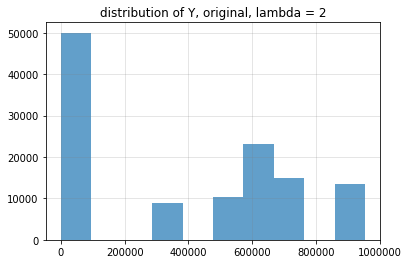

In [320]:
plot_Y(Y, 'original')

Optimal lambda for Box-Cox transformation on this dataset: [0.30223777]


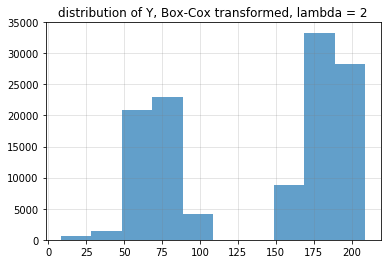

In [322]:
# find optimal lambda & use it to transform Y 
# into more normal-distribution-resembling shape
plot_Y(Y, 'Box-Cox transformed', boxcox_transform=True)

## 3) Performance evaluation
- The common approaches to measure forecast accuracy include scale-dependent ones (eg. number of units between actual sold quantities and predicted quantities) and scale-independent ones (the percentage of units). 
- Measures used here include: R2, adjusted R2, RMSE, MAPE
- Choos[forecast accuracy measurements](https://robjhyndman.com/papers/mase.pdf) depending on task at hand.

### R2 
R2 score can be an initial measure the performance of the KNN regressor and helps parameter-tuning. 
It measures the proportion of variance in orginal data that is explained by the model. A model with high R2 score (close to 1) indicates a good model fit to the dataset: the estimated function can help to explain a large percentage of variability in Y.

<center>
$R^2 = \frac{SSR}{SST} = \frac{\sum{(\hat{y}_i-\bar{y})^2}}{\sum{(y_i-\bar{y})^2}}$
</center>

R2 also has the following limitations: 
- always increase with more variables (even if the added variable is not related to Y)
- a blind pursuit for high R2 leads to overfitting.

### Adjusted R2

Adjusted R2 improves upon R2 to mitigate the risk of overfitting. It penalizes adding too many variables to the model (p is the number of variables and N is the number of samples)

<center>
$Adjusted\:R^2 = 1 - \frac{(1-R^2)(N-1)}{N-p-1}$
</center>

### RMSE (root of mean squared error)
- [Mean Squared Error (MSE)](https://en.wikipedia.org/wiki/Mean_squared_error) measures the average of the squares of errors. It is always greater than 0 and a value close to 0 is better. Since it puts a very high weight on large deviations, it is better to use [RMSE (root mean squared error)](https://lh4.googleusercontent.com/GD-CcmSDeb1ficAt41u0ZDtFd7syTpJGc_NJ3NGTlQtY-rikX7Tqn9DMaG4b5JtWlKOI6RBayJZNxr4h5SHL2SeKX9ceQCLj9uGTuqeAfgS0EDjh20oZnImahJ2oUa3up9E7KjI): 

<center>
    $RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n} \sum_{j=1}^{n} (y_j - \hat{y}_j)^2} $
</center>

### MAPE (mean absolute percentage error)
[MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) provides a more intuitive and scale-independent measure of how the regressor perform on actual data. The goal is to minimize this statistics since we want small errors between predictions and true values.
![alt text](https://i.stack.imgur.com/8Wdgw.png)
[drawbacks](https://stats.stackexchange.com/questions/299712/what-are-the-shortcomings-of-the-mean-absolute-percentage-error-mape):
- asymmetric - using MAPE to evaluate model performance encourages underforecast: equal errors above the actual value have greater APEs than those below the actual value;
- does not work when Y is (or close to) 0

### Studentized Residual Plots: identify outliers and heteroscedasticity
To check for the risk of overfitting, plot residuals (actual Y - predicted Y) against predicted Y (y-hat) and analyze the distribution of residuals. Studentized residuals takes into account the variance of residuals: if the theoretical assumption of homoskedastic (error variance is constant) is violated, the data is heteroscedastic.

Internally studentized residual is calculated by

<center>
$\hat{\sigma}^2 = \frac{1}{n-m} \sum_{j=1}^{n} \hat{\epsilon_j}^2$
</center>

where $m$ is the number of parameter in the model and $n$ is the sample size. 

It also helps to detect outliers that may affect model performance and evaluation

In [9]:
def calculate_adj_r2(r2, n, p):
    return 1 - (1-r2) * (n-1)/(n-p-1)

def mape(Y_test, Y_pred):
    Y_test, Y_pred = np.array(Y_test), np.array(Y_pred)
    return np.mean((np.abs(Y_test-Y_pred)/Y_test)) * 100

def cross_val_mape(model, X_, Y_, fold=5, rand_seed=None):
    
    X_train, X_test, Y_train, Y_test = [], [], [], []
    
    kf = KFold(n_splits=fold, random_state=rand_seed)
    
    for train_indices, test_indices in kf.split(X_, Y_):
        X_train, X_test = X_[train_indices], X_[test_indices]
        Y_train, Y_test = Y_[train_indices], Y_[test_indices]
    
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    mape_score = mape(Y_test, Y_pred)
    
    return mape_score

## OLS - linear regression
hypothesis test (t-test and p-value) 

In [10]:
def ols_(data):
    X = data[['ProductCategory','dealer_volume_group','month']].values
    Y = data['monthly_sum_Order_Qty'].values.reshape(-1,1)
    
    X = sm.add_constant(X)
    mod = sm.OLS(Y, X)
    res = mod.fit()
    
    return res.summary()

def OLS(X, Y, feature_list=None, boxcox_transform=False):  # call split_data() first to generate X and Y
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train, _ = boxcox(Y_train)
        Y_test, _ = boxcox(Y_test)
    
    lr = LinearRegression()
    model = lr.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred)
    
    print("OLS with features {} \n \
        RMSE: {} \n Adjusted R2: {} \n \
        MAPE: {}%".format(feature_list, rmse, adj_r2, MAPE))
    

def ols_volume_gp_ttest(data, groupNumber, month):
    local_data = data.loc[(data['dealer_volume_group'] == groupNumber)
                        & (data['month'] == month)]

    X = local_data[['SalesOffice','Order_Type','ProductCategory','MasterSKU',
                    'State','District']].values
    Y = local_data['monthly_sum_Order_Qty'].values.reshape(-1, 1)
    
    print("Month: {}\nVolume group: {}\n# of records: {}".format(month,groupNumber,len(X)))
    
    X = sm.add_constant(X)
    mod = sm.OLS(Y, X)
    res = mod.fit()
    
    return res.summary()

In [143]:
ols_(aggr_data)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.479
Method:                 Least Squares   F-statistic:                 1.844e+05
Date:                Thu, 12 Jul 2018   Prob (F-statistic):               0.00
Time:                        11:47:20   Log-Likelihood:            -8.3142e+06
No. Observations:              602653   AIC:                         1.663e+07
Df Residuals:                  602649   BIC:                         1.663e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.138e+06   1187.402    958.335      0.000    1.14e+06    1.14e+06
x1         -2.911e+05    392.126   -742.371      0.000   -2.92e+05    -2.9e+05
x2          4764.4763    394.461     12.078      0.000    3991.345    5537.608
x3         -4166.7829     98.482    -42.310      0.000   -4359.804   -3973.762
==============================================================================
Omnibus:                   144091.594   Durbin-Watson:                   1.425
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           498274.495
Skew:                          -1.191   Prob(JB):                         0.00
Kurtosis:                       6.765   Cond. No.                         27.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
OLS(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], boxcox_transform=False)

OLS with features ['ProductCategory', 'dealer_volume_group', 'month'] 
         RMSE: 56526828228.98633 
 Adjusted R2: 0.4763639693196411 
         MAPE: -73.06991106563086%


In [27]:
OLS(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], boxcox_transform=True)

C:\Users\Edith.Zeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


mape score list: 16.37967033394067
OLS with features ['ProductCategory', 'dealer_volume_group', 'month'] 
         RMSE: 1845.1518050320315 
 Adjusted R2: 0.4927017782590701 
         MAPE: 16.37967033394067%


In [296]:
ols_volume_gp_ttest(aggr_data, groupNumber=3, month=3)

Month: 3
Volume group: 3
# of records: 2221


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.709
Method:                 Least Squares   F-statistic:                     901.7
Date:                Wed, 11 Jul 2018   Prob (F-statistic):               0.00
Time:                        09:12:16   Log-Likelihood:                -29467.
No. Observations:                2221   AIC:                         5.895e+04
Df Residuals:                    2214   BIC:                         5.899e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.184e+05   1.65e+05      5.558      0.000    5.94e+05    1.24e+06
x1          5.488e+04   7658.179      7.166      0.000    3.99e+04    6.99e+04
x2          2.535e+05   8.11e+04      3.125      0.002    9.44e+04    4.13e+05
x3          -3.16e+05   4616.338    -68.444      0.000   -3.25e+05   -3.07e+05
x4         -6720.3945    372.465    -18.043      0.000   -7450.811   -5989.978
x5         -1707.3674    423.981     -4.027      0.000   -2538.809    -875.925
x6         -3227.6923    946.275     -3.411      0.001   -5083.372   -1372.012
==============================================================================
Omnibus:                     2228.591   Durbin-Watson:                   1.724
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           105161.061
Skew:                          -4.947   Prob(JB):                         0.00
Kurtosis:                      35.225   Cond. No.                     2.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
def ols_volume_gp(data, groupNumber, month):
    
    local_data = data.copy().loc[(data.dealer_volume_group == groupNumber)
                                & ((data['month'] == month))]
    sc = StandardScaler()
    X = sc.fit_transform(local_data[['Order_Type', 'ProductCategory', 
                                     'MasterSKU', 'City',  'Zipcode',
                                     'District', 'year']].values)
    Y = local_data['monthly_sum_Order_Qty'].values.reshape(-1, 1)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                        test_size=.2, 
                                                        random_state=19)
    lr = LinearRegression()
    lr.fit(X_train, Y_train)
    
    print("Month: {}\nVolume group: {}\n# of records: {}".format(month,groupNumber,len(X)))
    fig, ax = plt.subplots()
    predicted = cross_val_predict(lr, X_train, Y_train, cv=5)

    ax.scatter(Y_train, predicted, edgecolors=(0,0,0))
    ax.plot([Y_train.min(), Y_train.max()], 
            [Y_train.min(), Y_train.max()], 
            'k--', lw=1)
    ax.set_xlabel('measured')
    ax.set_ylabel('predicted')
    
    plt.show()
    
    del fig, ax

#### The same small volume group (group 3) has large variations across different months

Month: 4
Volume group: 3
# of records: 1394


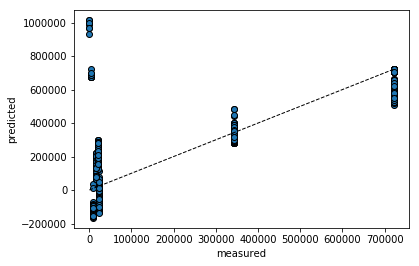

In [298]:
ols_volume_gp(aggr_data, 3, 4)

Month: 7
Volume group: 3
# of records: 1205


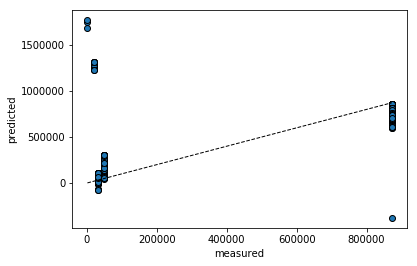

In [306]:
ols_volume_gp(aggr_data, 3, 7)

Month: 12
Volume group: 3
# of records: 4857


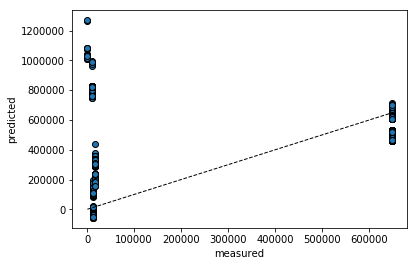

In [305]:
ols_volume_gp(aggr_data, 3, 12)

#### Data points from the large volume group (group 1) also don't fit well to the linear regression model.
#### Pearson coefficient will likely show a strong positive correlation but wrong in this situation. The linear OLS fit indicates that our dataset probrbaly don't satisfies the assumed statistical requirements for OLS.

Month: 3
Volume group: 1
# of records: 7958


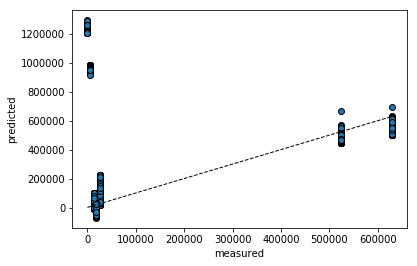

In [307]:
ols_volume_gp(aggr_data, 1, 3)

Month: 9
Volume group: 1
# of records: 5602


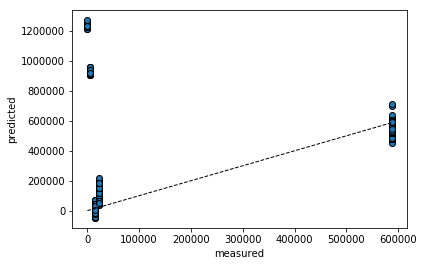

In [309]:
ols_volume_gp(aggr_data, 1, 9)

### Linear OLS results:
The low R2 score and plots indicate that OLS multiple linear regression does not fit well to the dataset. This is likely due to many reasons, most likely violations of some of the aforementioned assumptions of OLS:
- the relationship between X and Y are highly non-linear
    - This can be fixed by polynomial regression or smoothing spline but it's difficult to determine the correct degree of polynomials (not good when exponents are greater than 4)
- spherical errors
    - the error terms have different variances (not homoscedastic) and/or has autocorrelation
    - In other words, the error terms of different observations are likely correlated with each other, making the dataset a better candidate for time series modelling

### Polynomial OLS regession

In [11]:
def polynomial_regression(X, Y, feature_list, d, boxcox_transform=False):
    
    # center and scale X; box-cox transform Y
    sc = StandardScaler()
    X = sc.fit_transform(X)
    if boxcox_transform:
        Y, _ = boxcox(Y)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=12)
    
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('linear', LinearRegression())
    ])
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    # cross validate & evaluate performance
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred)
    
    print("Method: {} degree: {} \nRMSE: {}\n\
        Adjusted R2: {}\nMAPE :{}%".format(
        'Polynomial OLS', d, rmse, adj_r2, MAPE
    ))
    
    # calculate internally studentized residuals
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    # visualize internally studentized residuals
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('Polynomial Linear Regression, degree = {}\ninternally studentized residuals'.format(d))
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

Method: Polynomial OLS degree: 2 
RMSE: 50993473753.26705
        Adjusted R2: 0.527492282115459
MAPE :-15.193139089553565%


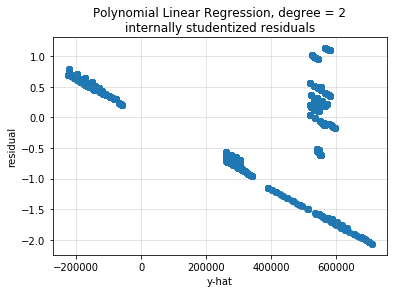

In [48]:
import warnings
warnings.filterwarnings("ignore")

# 20% data
polynomial_regression(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], d=2, boxcox_transform=False)

Method: Polynomial OLS degree: 2 
RMSE: 1407.534872044056
        Adjusted R2: 0.5869972020040275
MAPE :30.033999628478213%


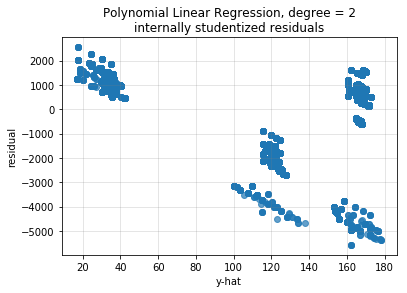

In [46]:
# 20% data
polynomial_regression(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], d=2, boxcox_transform=True)

Method: Polynomial OLS degree: 3 
RMSE: 631.0927614914397
        Adjusted R2: 0.8148200707152924
MAPE :8.02163598351223%


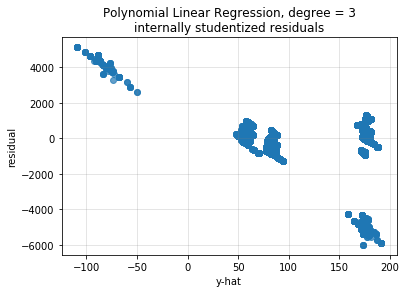

In [45]:
# 20% data
polynomial_regression(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], d=3, boxcox_transform=True)

Method: Polynomial OLS degree: 3 
RMSE: 592.4566045363849
        Adjusted R2: 0.8161560377278155
MAPE (not cross validated):[18.85918169]%


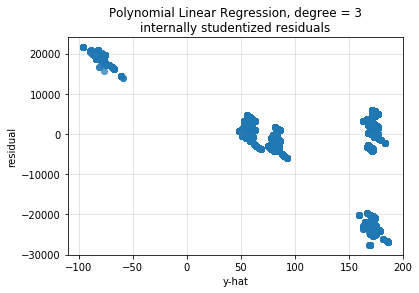

In [150]:
# polynomial_regression(X_90, Y_90, feature_list=['ProductCategory','dealer_volume_group','month'], d=3, boxcox_transform=True)

Method: Polynomial OLS degree: 4 
RMSE: 149.34485547380336
        Adjusted R2: 0.953651286965438
MAPE (not cross validated):[8.39847866]%


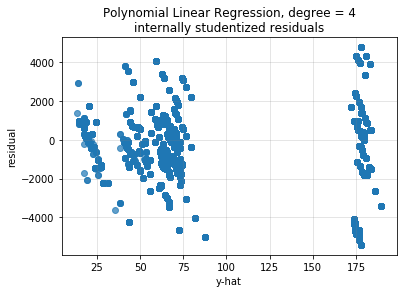

In [151]:
polynomial_regression(X_90, Y_90, feature_list=['ProductCategory','dealer_volume_group','month'], d=4, boxcox_transform=True)

Method: Polynomial OLS degree: 4 
RMSE: 15299584613.612797
        Adjusted R2: 0.8582767184107093
MAPE :13.31095662713208%


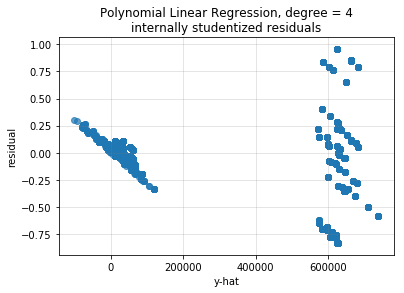

In [44]:
polynomial_regression(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], d=4, boxcox_transform=False)

Method: Polynomial OLS degree: 4 
RMSE: 158.5824770115452
        Adjusted R2: 0.9534793363479541
MAPE :6.070000430282309%


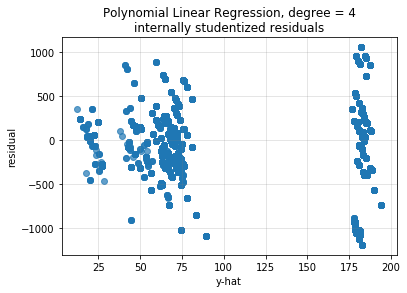

In [43]:
polynomial_regression(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'], d=4, boxcox_transform=True)

## 2.2) Algorithm and Model Selection - Local Learning
### KNN Regressor (non-weighted Euclidean distance)
Advantages: 
- measures the similarities between nearby observations
- no assumption on the underlying process of the data
    - no assumption on properties of noise, existence of a global function, etc
- good for datasets with missing features, non-stationarity and/or measurement errors
    - assumption-free and data-driven approach
- non-parametric: 
    - allows online learning for future data feeding
    - scales well with more incoming observations
- models non-stationarity: deals with sitations when the stochastic process underlying the data is non-stationary

Disadvantages:
- very little understanding of the underlying structure/function
    - prediction > inference
    - not much of a model to interpret

In [12]:
def local_knn(X_,Y_,lo,hi, boxcox_transform=False, lambda_=None):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train = boxcox(Y_train, lmbda=lambda_)
        Y_test = boxcox(Y_test, lmbda=lambda_)
    
    # cross validate
    r2_list = []
    for k in range(lo, hi):
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(X_, Y_)    
        r2 = np.mean(cross_val_score(knn, X_, Y_, scoring='r2'))
        r2_list.append(r2)
    print("cross validated {} of values for K".format(len(r2_list)))
    
    n = len(X_)     # number of observations
    p = len(X_[0])  # number of features
    adj_r2_list = [calculate_adj_r2(r2, n, p) for r2 in r2_list]
    print("Best adjusted R2: {}".format(np.amax(adj_r2_list)))
    
    return adj_r2_list
    
# plot KNN results (adjusted R2)
def plot_knn_results(lo, hi, k_adj_r2):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], k_adj_r2
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("Adjusted R2")

### Feature selection
- The high R2 score indicates a good fit to the data: the KNN regressor is not underfitting the data
- The next step is to check if the model and fits _too well_ to the training data (does not generalize well on new datasets), aka overfit. This is particularly a concern with a very flexible method
- Since the adjusted R2 scores are very high, reducing _p_ from 6 to 3 features (month, ProductCategory, dealer volume group) can reduce the risk of overfitting (removed: color, Zipcode, district)

In [314]:
print("number of features:", len(X[1]))

number of features: 3


cross validated 47 of values for K
Best adjusted R2: 0.9646985014318534


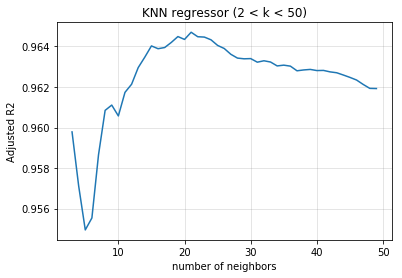

In [315]:
import warnings
warnings.filterwarnings("ignore")

# results from using 20% data, 3 features, K from 2 to 34 inclusive
KNN_adj_r2 = local_knn(X,Y,lo=3,hi=50)
plot_knn_results(3, 50, KNN_adj_r2)

Using adjusted R2 as the performance metric, the KNN regressor achieves best performance at K = 21 where the adjusted R2 is over 96.4%.

cross validated 48 of values for K
Best adjusted R2: 0.9646985014318534


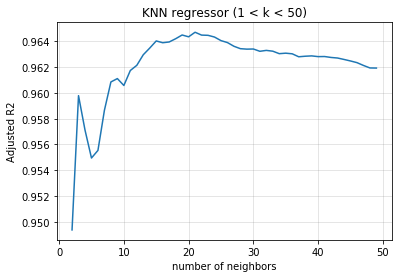

In [324]:
all_k_adj_r2_boxcox = local_knn(X,Y,lo=2,hi=50,boxcox_transform=True,lambda_=0.30223777)
plot_knn_results(2,50,all_k_adj_r2_boxcox)

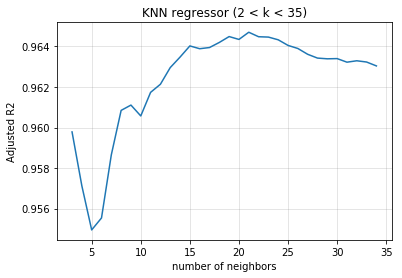

In [168]:
all_k_adj_r2_boxcox = local_knn(X,Y,lo=2,hi=35,boxcox_transform=True,lambda_=0.30223777)
plot_knn_results(2,35,all_k_adj_r2_boxcox)

##### After Box-Cox transformation, the optimal K is still around K = 21 with adjusted R2 over 96.4%

In [13]:
# residual, non-studentized
def local_knn_resplot(X,Y,k,boxcox_transform=False, lambda_=None):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    
    if boxcox_transform:
        Y_train = boxcox(Y_train, lmbda=lambda_)
        Y_test = boxcox(Y_test, lmbda=lambda_)
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    res = Y_test - Y_pred
    
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('knn regressor (k = {}) residuals'.format(k))
    ax1.set_ylabel('e')
    ax1.set_xlabel('y-hat')

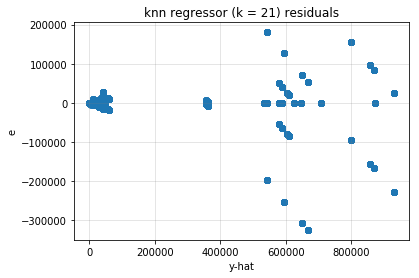

In [162]:
# knn K = 21, 20% of all data
local_knn_resplot(X, Y, 21)

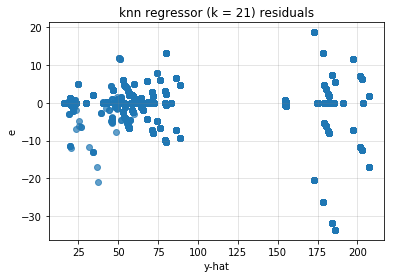

In [176]:
# K = 21, 20% of all data, box-cox transformed
local_knn_resplot(X, Y, 21, boxcox_transform=True, lambda_=0.30223777)

In [14]:
# interally studentized residuals
def local_knn_resplot_studentized(X, Y, k, boxcox_transform=False, lambda_=None):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train = boxcox(Y_train,lmbda=lambda_)
        Y_test = boxcox(Y_test,lmbda=lambda_)
    
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
     
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('knn regressor (k = {}) residuals'.format(k))
    ax1.set_ylabel('e')
    ax1.set_xlabel('y-hat')

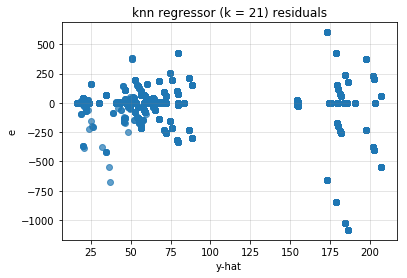

In [179]:
local_knn_resplot_studentized(X, Y, 21, boxcox_transform=True, lambda_=0.30223777)

## Heteroskedasticity 
The residual plot and studentized residual plot above shows the problem with heteroskedasticity (variance of Y depends on the value of X)

Factors contributing to heteroscedasticity: 
- Cross-sectional modelling: Y has large variance (very small to very large value)
- Time series: if Y changes significantly from the beginning to the end of the series

Due to hetroscedasticity, methods that are not appropriate:
- (Pearson) correlation
- t-test, f-test and p-value -- cannot perform reliable variable selection based on hypothesis test
- ANOVA
- OLS regression's estimated coefficients are biased

Ways to address the problem:
- add more useful variables (if an important variable is omitted, its effects add up to the error term)
- Box-Cox transformation on Y
- weighted least square regression

In [15]:
def local_knn_rmse(X_,Y_,lo,hi,boxcox_transform=False, lambda_=None):
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train = boxcox(Y_train, lmbda=lambda_)
        Y_test = boxcox(Y_test, lmbda=lambda_)
    
    # cross validate
    score_list = []
    for k in range(lo, hi):
        knn = KNeighborsRegressor(n_neighbors = k)
        knn.fit(X_, Y_)    
        rmse = np.sqrt(np.mean(-1 * cross_val_score(knn, X_, Y_, scoring='neg_mean_squared_error')))
        score_list.append(rmse)
    print("cross validated {} of values for K".format(len(score_list)))
    print("Best adjusted MSE: {}".format(np.amin(score_list)))
    
    return score_list
    
# plot KNN results (adj r2)
def plot_knn_results(lo, hi, score_list):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], score_list
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("RMSE")

cross validated 53 of values for K
Best adjusted MSE: 61770.614477468596


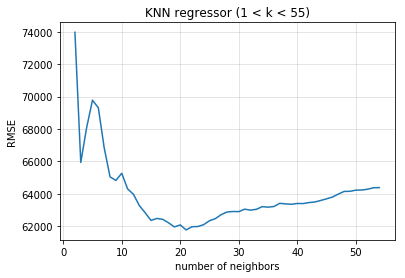

In [181]:
rmse_list = local_knn_rmse(X, Y, 2, 55)
plot_knn_results(2,55,rmse_list)

cross validated 53 of values for K
Best adjusted MSE: 61770.614477468596


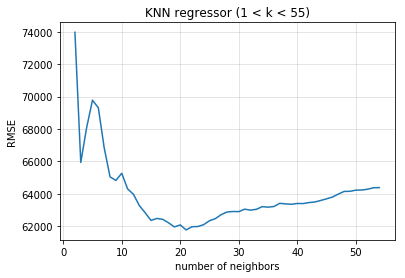

In [182]:
rmse_list_boxcox = local_knn_rmse(X, Y, 2, 55, boxcox_transform=True, lambda_=0.30223777)
plot_knn_results(2, 55, rmse_list_boxcox)

In [16]:
# cross validate with mape scoring
def cross_val_mape_knn(k, X_, Y_, fold=5, rand_seed=None):
    
    X_train, X_test, Y_train, Y_test = [],[],[],[]
    
    kf = KFold(n_splits=fold, random_state=rand_seed)
    for train_indices, test_indices in kf.split(X_, Y_):
        X_train, X_test = X_[train_indices], X_[test_indices]
        Y_train, Y_test = Y_[train_indices], Y_[test_indices]
    
    knn = KNeighborsRegressor(n_neighbors = k)
    knn.fit(X_train, Y_train)
    
    Y_pred = knn.predict(X_test)
    mape_score = mape(Y_test, Y_pred)
    
    return mape_score

# find the best number of neighbors (lowest MAPE)
def local_knn_mape(X_,Y_, lo, hi, boxcox_transform=False):
    
    # center and scale
    sc = StandardScaler()
    X_ = sc.fit_transform(X_)
    if boxcox_transform: 
            Y_, bestlambda = boxcox(Y_)
            print("best lambda:", bestlambda)

    # cross validate
    score_list = []
    for k in range(lo, hi):
        score_list.append(cross_val_mape_knn(k, X_, Y_, rand_seed=19))

    return score_list


def plot_knn_results(lo, hi, score_list):
    fig2, ax2 = plt.subplots()
    X2, Y2 = [k for k in range(lo, hi)], score_list
    ax2.plot(X2, Y2)
    plt.grid(color='grey',linestyle='-', linewidth=1, alpha=.2)
    ax2.set_title("KNN regressor ({} < k < {})".format(lo-1,hi))
    ax2.set_xlabel("number of neighbors")
    ax2.set_ylabel("MAPE (percentage)")

In [191]:
knn_mape_score_list = local_knn_mape(X, Y, 3, 50)

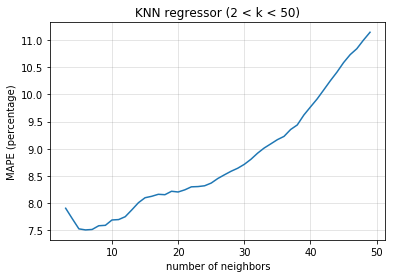

In [192]:
plot_knn_results(3,50,knn_mape_score_list)

best lambda: [0.30223777]


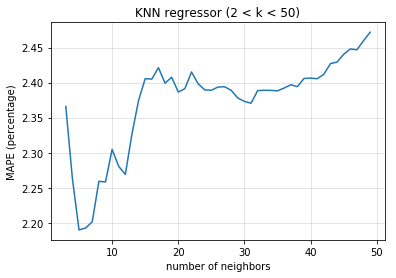

In [199]:
mape_knn_result = local_knn_mape(X, Y, 3, 50, boxcox_transform=True)
plot_knn_results(3, 50, mape_knn_result)

In [32]:
knn_mape_score_list = local_knn_mape(X, Y, 2, 10)

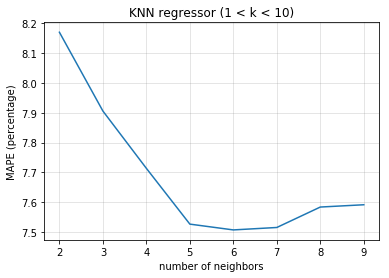

In [33]:
plot_knn_results(2,10,knn_mape_score_list)

In [ ]:
mape_knn_result_90 = local_knn_mape(X_90, Y_90, 2, 50, boxcox_transform=True)
plot_knn_results(2, 50, mape_knn_result_90)

# rmse_list_90 = local_knn_rmse(X, Y, 2, 50, boxcox_transform=True, lambda_=0.30223777)
# plot_knn_results(2, 50,rmse_list_90)

# adj_r2_list_90 = local_knn(X, Y, 2, 50, boxcox_transform=True, lambda_=0.30223777)
# plot_knn_results(2, 50, adh_r2_list_90)


In [46]:
def knn_final(X, Y, k, feature_list=None, boxcox_transform=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
    
    sc = StandardScaler()
    X_train, X_test = sc.fit_transform(X_train), sc.fit_transform(X_test)
    if boxcox_transform:
        Y_train, lambda_ = boxcox(Y_train)
        Y_test, lambda_ = boxcox(Y_test)
        
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    Y_pred = knn.predict(X_test)
    
    rmse = np.mean(-1 * cross_val_score(knn, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(knn, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(knn, Y_test, Y_pred)
    
    print("KNN with K = {} \n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {} \n \
        MAPE: {}%".format(k, rmse, adj_r2, MAPE))

In [52]:
knn_final(X, Y, k=21, feature_list=['ProductCategory','dealer_volume_group','month'])

KNN with K = 21 
         features considered at each split: all 
         RMSE: 3792125270.937037 
 Adjusted R2: 0.9652422920846111 
         MAPE: 1.1291371349491217%


In [53]:
knn_final(X, Y, k=21, feature_list=['ProductCategory','dealer_volume_group','month'], boxcox_transform=True)

KNN with K = 21 
         features considered at each split: all 
         RMSE: 42.129923487779095 
 Adjusted R2: 0.9883672719150628 
         MAPE: 0.3329950489346145%


In [54]:
knn_final(X, Y, k=6, feature_list=['ProductCategory','dealer_volume_group','month'])

KNN with K = 6 
         features considered at each split: all 
         RMSE: 3940921395.0987196 
 Adjusted R2: 0.9613886227688851 
         MAPE: 1.1141379918936234%


In [55]:
knn_final(X, Y, k=6, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

KNN with K = 6 
         features considered at each split: all 
         RMSE: 42.78682193560842 
 Adjusted R2: 0.987720923725222 
         MAPE: 0.3601573780870499%


## Random Forest

In [10]:
aggr_data.shape

(602653, 22)

In [18]:
import warnings
warnings.filterwarnings("ignore")

def random_forest_reg(X, Y, max_depth=3, feature_list=None, boxcox_transform=False):
    """ using all CPU cores, memory intensive """
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    if boxcox_transform:
        Y, _ = boxcox(Y)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                        test_size=0.3,
                                                        random_state=12)
        
    model = RandomForestRegressor(bootstrap=True,random_state=0,max_depth=max_depth,n_jobs=-1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred) # not enough memory to calculate this for Random Forest
    
    print("Features:", feature_list)
    print("Random Forest with max depth = {}\n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {}\nMAPE: {}%".format(max_depth,rmse,adj_r2,MAPE))

In [64]:
random_forest_reg(X, Y, feature_list=['ProductCategory','dealer_volume_group','month'])

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = 3
         features considered at each split: all 
         RMSE: 14232161101.29768 
 Adjusted R2: 0.8681659124251336
MAPE: 22.136854242890315%


In [65]:
random_forest_reg(X, Y, max_depth=4, feature_list=['ProductCategory','dealer_volume_group','month'])

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = 4
         features considered at each split: all 
         RMSE: 10085850659.835157 
 Adjusted R2: 0.9065785633852359
MAPE: 13.514803276148186%


In [66]:
random_forest_reg(X, Y, max_depth=None, feature_list=['ProductCategory','dealer_volume_group','month'])

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = None
         features considered at each split: all 
         RMSE: 3640080553.4034476 
 Adjusted R2: 0.9662998352666071
MAPE: 0.7770919423997525%


In [70]:
random_forest_reg(X, Y, max_depth=None, feature_list=['ProductCategory','dealer_volume_group','month'], boxcox_transform=True)

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = None
         features considered at each split: all 
         RMSE: 36.78763655797567 
 Adjusted R2: 0.9892102361232773
MAPE: 0.2586601589049621%


## test models on data from June 2018

In [84]:
conn = pyodbc.connect("Driver={ODBC Driver 13 for SQL Server};Server=yetidb01.database.windows.net;database=YETISQLDW01;uid=ezeng;PWD=Ed1tH2EnG#")
cursor = conn.cursor()

qry1 = """
SELECT S.CustomerID, C.Customer, S.OrderDate, S.Requested_Date, S.SalesOffice, S.OrderQty, P.ProductCategory, P.MasterSKU
FROM EDW_DS.ORDERFCT S 
inner join [EDW].[PRODUCT_DIM] P ON P.ProductID = S.ProductID 
left join EDW_DS.CUSTOMER_DIM C on S.CustomerID = C.CustomerID
WHERE P.ISCORE = 'TRUE' and S.SalesOffice in ('STD','HYB') 
and S.RejectionReason is null
and S.Ordertype Not in ('ZARF','ZARM','ZEG2','ZERF','ZERM','ZRE') and S.SoldtoParty not in ('91860','0000107894','0000114883','0000108654')
and S.OrderDate >= '2018-06-01' and S.OrderDate <= '2018-06-30'
order by OrderDate ASC
"""

test_data = pd.read_sql(qry1, conn)

In [85]:
test_data.head(2)

,CustomerID,Customer,OrderDate,Requested_Date,SalesOffice,OrderQty,ProductCategory,MasterSKU
0,107397,Marine Corps Exchange,2018-06-01,2018-06-15,HYB,6,Drinkware,R20 Tumbler
1,107397,Marine Corps Exchange,2018-06-01,2018-06-15,HYB,6,Drinkware,R20 Tumbler


In [86]:
test_data['CustomerID'] = test_data['CustomerID'].apply(lambda x: x.zfill(10))

In [87]:
test_data.tail(2)

,CustomerID,Customer,OrderDate,Requested_Date,SalesOffice,OrderQty,ProductCategory,MasterSKU
31139,0000114504,Whole Foods Market,2018-06-30,2018-07-07,HYB,2,Drinkware,R20 Tumbler
31140,0000114504,Whole Foods Market,2018-06-30,2018-07-10,HYB,5,Drinkware,R20 Tumbler


In [25]:
%store -r volume_groups

In [89]:
def add_test_data_cols():
    test_data['dealer_volume_group'] = test_data.apply(lambda _: '', axis=1)
    for i, row in test_data.iterrows():
        try: 
            test_data.at[i, 'dealer_volume_group'] = volume_groups[row[0]]
        except KeyError:   # skip new dealers
            continue
add_test_data_cols()
test_data.columns

Index(['CustomerID', 'Customer', 'OrderDate', 'Requested_Date', 'SalesOffice',
       'OrderQty', 'ProductCategory', 'MasterSKU', 'dealer_volume_group'],
      dtype='object')

In [90]:
test_data.drop(columns=['CustomerID', 'Customer','OrderDate','Requested_Date', 'SalesOffice'], inplace=True)

In [91]:
test_data.shape

(31141, 4)

In [92]:
test_data.columns

Index(['OrderQty', 'ProductCategory', 'MasterSKU', 'dealer_volume_group'], dtype='object')

In [95]:
def update_monthly_sum(dFrame):
            
    new_dFrame = dFrame.copy()
    new_dFrame['monthly_sum_Order_Qty'] = np.nan
    hi = len(dFrame)

    for i, row in dFrame.iterrows():
        
        subset = dFrame.loc[(dFrame['ProductCategory'] == row[1])
                            & (dFrame['dealer_volume_group'] == row[3])]
        
        subset_order_sum = subset['OrderQty'].sum(min_count=1)

        new_dFrame.loc[(
                        (np.isnan(new_dFrame['monthly_sum_Order_Qty']))
                        & (dFrame['ProductCategory'] == row[1])
                        & (dFrame['dealer_volume_group'] == row[3])
                        ), 'monthly_sum_Order_Qty'] = subset_order_sum
            
        if (i % 1000) == 0 and i <= hi:
            sys.stdout.write('\r'+"{0:.3%}".format(i/hi))
            sys.stdout.flush()
            
    return new_dFrame

In [96]:
df = update_monthly_sum(test_data)

99.547%

In [97]:
df.sample(10)

,OrderQty,ProductCategory,MasterSKU,dealer_volume_group,monthly_sum_Order_Qty
22572,1,Hard Cooler,Tundra 35,0,11617.0
8371,6,Drinkware,R10 Lowball,1,87355.0
6307,2,Hard Cooler,Tundra 105,0,11617.0
29229,2,Hard Cooler,Tundra 35,2,2777.0
23219,6,Drinkware,R20 Tumbler,0,137448.0
17756,102,Drinkware,R20 Tumbler,0,137448.0
18941,12,Drinkware,R30 Tumbler,3,123503.0
18424,6,Drinkware,R10 Lowball,0,137448.0
31054,2,Hard Cooler,Tundra 35,0,11617.0
23503,6,Drinkware,R20 Tumbler,1,87355.0


In [98]:
def encode_categorical_predictors(dFrame):
    op = dFrame.copy()
    le = LabelEncoder()
    for c in ['ProductCategory', 'MasterSKU']:
        op[c] = le.fit_transform(op[c].astype(str))
    return op

In [99]:
df_num = encode_categorical_predictors(df)

In [100]:
df_num.sample(2)

,OrderQty,ProductCategory,MasterSKU,dealer_volume_group,monthly_sum_Order_Qty
4237,1,4,9,0,8204.0
4369,48,4,0,2,1564.0


In [119]:
df_num['month'] = df.apply(lambda _:6, axis=1)

In [104]:
df_num.sample(2)

,OrderQty,ProductCategory,MasterSKU,dealer_volume_group,monthly_sum_Order_Qty,month
11021,12,2,23,0,137448.0,6
30926,72,2,23,0,137448.0,6


In [116]:
df_num.empty

False

In [121]:
df_num['dealer_volume_group'] = pd.to_numeric(df_num['dealer_volume_group'])

In [123]:
df_num[['ProductCategory','dealer_volume_group', 'month']].isnull().any()

ProductCategory        False
dealer_volume_group     True
month                  False
dtype: bool

In [125]:
df_num['dealer_volume_group'] = df_num['dealer_volume_group'].fillna(value=-1)

In [139]:
def knn_test(X, Y, test_data_X, test_data_Y, k=21, feature_list=None, boxcox_transform=False):
    sc = StandardScaler()
    X = sc.fit_transform(X)
    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
    
    #X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.3, random_state=12)
    X_train, Y_train = X, Y

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, Y_train)
    
    X_test = sc.transform(test_data_X)
    Y_test = boxcox(test_data_Y,lmbda=best_lambda).reshape(-1,1)
    Y_pred = knn.predict(X_test)
    
    rmse = np.mean(-1 * cross_val_score(knn, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(knn, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(knn, Y_test, Y_pred)
    
    print("KNN with K = {} \n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {} \n \
        MAPE: {}%".format(k, rmse, adj_r2, MAPE))

In [128]:
test_data_X = df_num[['ProductCategory','dealer_volume_group', 'month']].values
test_data_Y = df_num['monthly_sum_Order_Qty'].values

In [138]:
# using 70% of X, Y (20% of entire dataset)
knn_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

KNN with K = 21 
         features considered at each split: all 
         RMSE: 39.30151720215849 
 Adjusted R2: 0.9884118529141718 
         MAPE: 0.1964421171087237%


In [140]:
# use 100% of X, Y (20% of entire dataset)
knn_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

KNN with K = 21 
         features considered at each split: all 
         RMSE: 38.49480051731629 
 Adjusted R2: 0.9887974115731968 
         MAPE: 0.19643869891812754%


In [188]:
def random_forest_test(X, Y, test_data_X, test_data_Y, max_depth=None, feature_list=None, boxcox_transform=False, draw_tree=False):
    """ using all CPU cores, memory intensive """
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
    
    #X_train, _, Y_train, _ = train_test_split(X, Y, test_size=0.3,random_state=12)
    X_train, Y_train = X, Y
    X_test = sc.transform(test_data_X)
    Y_test = boxcox(test_data_Y, lmbda=best_lambda).reshape(-1,1)
        
    model = RandomForestRegressor(bootstrap=True,random_state=0,max_depth=max_depth,n_jobs=-1)
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    
    if draw_tree:   # plot a tree
        graph = Source(export_graphviz(model.estimators_[0],out_file='tree.jpeg'))

    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred) # not enough memory to calculate this for Random Forest
    
    print("Features:", feature_list)
    print("Random Forest with max depth = {}\n \
        features considered at each split: all \n \
        RMSE: {} \n Adjusted R2: {}\nMAPE: {}%".format(max_depth,rmse,adj_r2,MAPE))
    
    return model

In [173]:
# use 70% of X, Y (20% of entire dataset)
random_forest_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = None
         features considered at each split: all 
         RMSE: 36.875573926980756 
 Adjusted R2: 0.9891778485297046
MAPE: 0.015788807550411083%


In [189]:
# use 100% of X, Y (20% of entire dataset)
rf = random_forest_test(X, Y, test_data_X, test_data_Y, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True,draw_tree=True)

Features: ['ProductCategory', 'dealer_volume_group', 'month']
Random Forest with max depth = None
         features considered at each split: all 
         RMSE: 36.875573926980756 
 Adjusted R2: 0.9891778485297046
MAPE: 0.015788807550396005%


In [191]:
rf.estimators_[0]

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=209652396, splitter='best')

In [160]:
def polynomial_regression(X, Y, test_data_X, test_data_Y, feature_list, d, boxcox_transform=False):
    
    sc = StandardScaler()
    X = sc.fit_transform(X)
    X_train, Y_train = X, Y
    X_test = sc.transform(test_data_X)    
    if boxcox_transform:
        Y, best_lambda = boxcox(Y)
        Y_test = boxcox(test_data_Y, lmbda=best_lambda).reshape(-1,1)
    else:
        Y_test = test_data_Y.reshape(-1,1)
    
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=d)),
        ('linear', LinearRegression())
    ])
    model = model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test).reshape(-1,1)
    
    # cross validate & evaluate performance
    rmse = np.mean(-1 * cross_val_score(model, X_train, Y_train, 
                                   scoring='neg_mean_squared_error',
                                   cv=5))
    r2_list = cross_val_score(model, X_train, Y_train, scoring='r2')
    adj_r2 = np.mean([calculate_adj_r2(r2, len(X), len(feature_list)) for r2 in r2_list])
    MAPE = cross_val_mape(model, Y_test, Y_pred)
    
    print("Method: {} degree: {} \nRMSE: {}\n\
        Adjusted R2: {}\nMAPE :{}%".format(
        'Polynomial OLS', d, rmse, adj_r2, MAPE
    ))
    
    # calculate internally studentized residuals
    X_mean, Y_mean = sum(X_test)/len(X), sum(Y_test)/len(Y)
    res = Y_test - Y_pred
    Y_SD = np.sqrt(sum([(Y_i-Y_mean)**2 for Y_i in Y_test])/len(Y))
    Y_SE = Y_SD**2 / len(Y)
    stu_res = res / Y_SE
    
    # visualize internally studentized residuals
    fig1, ax1 = plt.subplots(1)
    ax1.scatter(Y_pred, stu_res, alpha=0.7)
    plt.grid(color='grey', linestyle='-', linewidth=1, alpha=.2)
    ax1.set_title('Polynomial Linear Regression, degree = {}\ninternally studentized residuals'.format(d))
    ax1.set_ylabel('residual')
    ax1.set_xlabel('y-hat')

Method: Polynomial OLS degree: 3 
RMSE: 627.7282820983431
        Adjusted R2: 0.8157293281542014
MAPE :8.425942232342374%


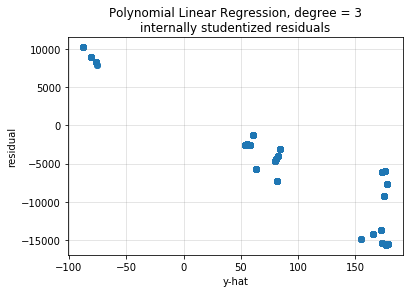

In [154]:
polynomial_regression(X, Y, test_data_X, test_data_Y, d=3, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

Method: Polynomial OLS degree: 4 
RMSE: 158.62498134195806
        Adjusted R2: 0.9534648819976895
MAPE :75318472.20764835%


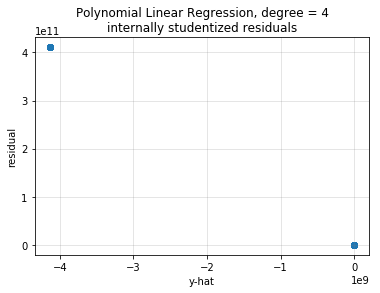

In [155]:
polynomial_regression(X, Y, test_data_X, test_data_Y, d=4, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=True)

Method: Polynomial OLS degree: 4 
RMSE: 15293161802.167843
        Adjusted R2: 0.8584984534463548
MAPE :837087572.734778%


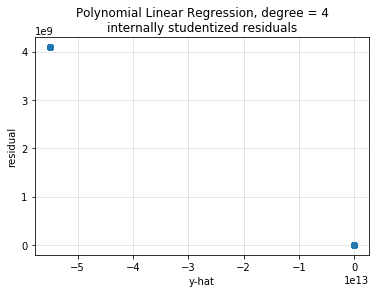

In [161]:
polynomial_regression(X, Y, test_data_X, test_data_Y, d=4, feature_list=['ProductCategory','dealer_volume_group','month'],boxcox_transform=False)